In [2]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("linear_model.txt",delimiter='\t',header=None)
data.columns=['x','y','dy']

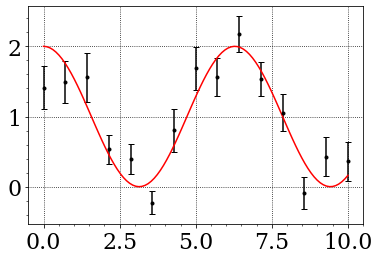

In [31]:
def new_f(x):
    return 1*np.cos(x)+1
xx=np.linspace(0,10,100)
x=np.linspace(0,10,15)
y=new_f(x)
dy=np.random.normal(0.25,0.05,len(y))
noise=np.random.normal(0,dy,len(y))
y+=noise
plt.errorbar(x=x,y=y,yerr=dy,fmt='.',label='generated noise')
plt.plot(xx,new_f(xx),label='true function')
noisy_data_dict={'x':x,'y':y,'dy':dy}
noisy_data=pd.DataFrame(data=noisy_data_dict)


In [20]:
def f(x,a,b):
    return a*np.cos(x)+b
def f1(x,a,b,c):
    return a*np.cos(x+c)+b

popt, pcov = curve_fit(f,data['x'].values,data['y'].values,p0=[2,2],sigma=data['dy'].values)
popt1, pcov1 = curve_fit(f1,data['x'].values,data['y'].values,p0=[2,2,0],sigma=data['dy'].values)

In [4]:
model = sp.CmdStanModel(stan_file='./stan_file.stan')
print(model.code())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/stan_file


data {
	int<lower=0> n;
	vector[n] x;
	vector[n] y;
	vector[n] dy;
}
parameters {
	real a;
	real b;
}

model {
	y ~ normal(b + a * cos(x), dy);
	a ~ normal(0,100);
	b ~ normal(0,100);
}
generated quantities {
	array[n] real y_tilde = normal_rng(b + a * cos(x),dy);
	vector[n] log_lik;
	for (k in 1:n){
    	log_lik[k]=normal_lpdf(y[k]|b + a * cos(x[k]), dy[k]);
    }
}



In [5]:
stan_data={'n':len(data['x'].values),
             'x':list(data['x'].values),
             'y':list(data['y'].values),
           'dy':list(data['dy'].values)
}

fit = model.sample(data=stan_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


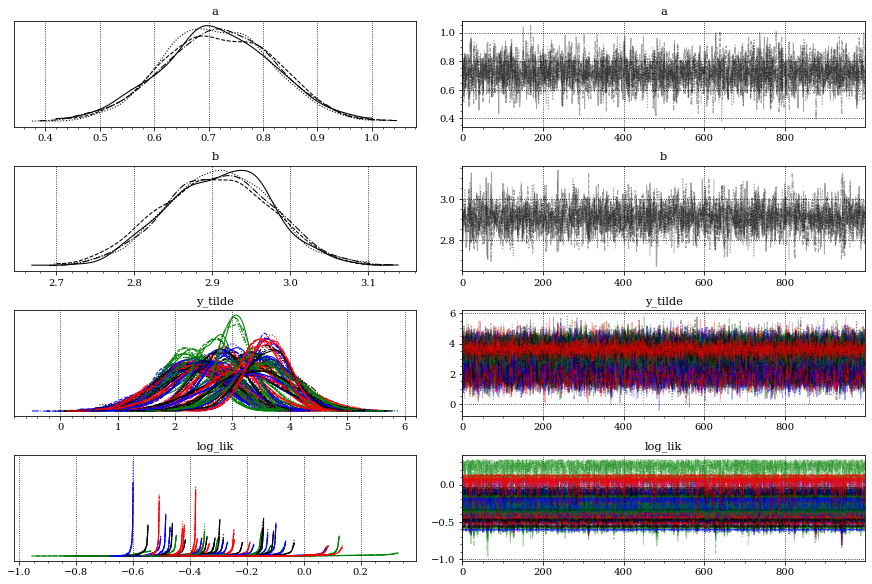

In [6]:
%%capture --no-display
warnings.filterwarnings('ignore')
az.plot_trace(fit)
plt.show()

In [7]:
samples=fit.draws_pd()
samples

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,y_tilde[1],...,log_lik[41],log_lik[42],log_lik[43],log_lik[44],log_lik[45],log_lik[46],log_lik[47],log_lik[48],log_lik[49],log_lik[50]
0,-2.000330,0.910490,0.817944,2.0,3.0,0.0,5.25027,0.861320,2.85244,4.05087,...,-0.557811,-0.511019,-0.600666,-0.151111,-0.462082,0.086226,-0.231860,-0.362388,-0.057921,0.116683
1,-2.121270,0.958932,0.817944,3.0,7.0,0.0,3.23414,0.702923,2.79272,2.66869,...,-0.592585,-0.515274,-0.615621,-0.214711,-0.503414,-0.029000,-0.178507,-0.368362,-0.076596,0.044204
2,-0.735002,1.000000,0.817944,2.0,3.0,0.0,1.94196,0.693764,2.92074,3.16356,...,-0.554697,-0.510691,-0.600387,-0.155425,-0.466639,0.075288,-0.189901,-0.348551,-0.033234,0.131953
3,-1.327530,0.918700,0.817944,2.0,3.0,0.0,1.36670,0.818549,2.93317,3.30973,...,-0.548703,-0.522406,-0.605750,-0.156540,-0.464277,0.074186,-0.266617,-0.377097,-0.083640,0.089217
4,-2.023060,0.926241,0.817944,3.0,7.0,0.0,2.22344,0.557498,2.89499,3.32063,...,-0.571148,-0.509942,-0.610335,-0.207565,-0.505132,-0.050119,-0.184202,-0.381683,-0.108533,-0.014655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-4.125710,0.740758,0.961048,1.0,1.0,0.0,4.31972,0.976400,2.89647,3.99041,...,-0.548083,-0.531191,-0.614747,-0.180458,-0.480251,0.003792,-0.380884,-0.442641,-0.212801,-0.074970
3996,-4.815250,0.848540,0.961048,1.0,1.0,0.0,5.42311,0.995775,2.93139,3.41112,...,-0.548260,-0.547231,-0.627247,-0.210347,-0.498035,-0.062103,-0.456856,-0.487657,-0.299275,-0.187921
3997,-2.370820,1.000000,0.961048,2.0,3.0,0.0,5.58379,0.734631,2.78118,3.58404,...,-0.593347,-0.514930,-0.614341,-0.208221,-0.498324,-0.011187,-0.176321,-0.362538,-0.063987,0.067022
3998,-0.812834,0.987129,0.961048,2.0,3.0,0.0,2.48939,0.722911,2.87587,3.07240,...,-0.562185,-0.508508,-0.601410,-0.162326,-0.470919,0.064784,-0.183762,-0.348668,-0.034275,0.126955


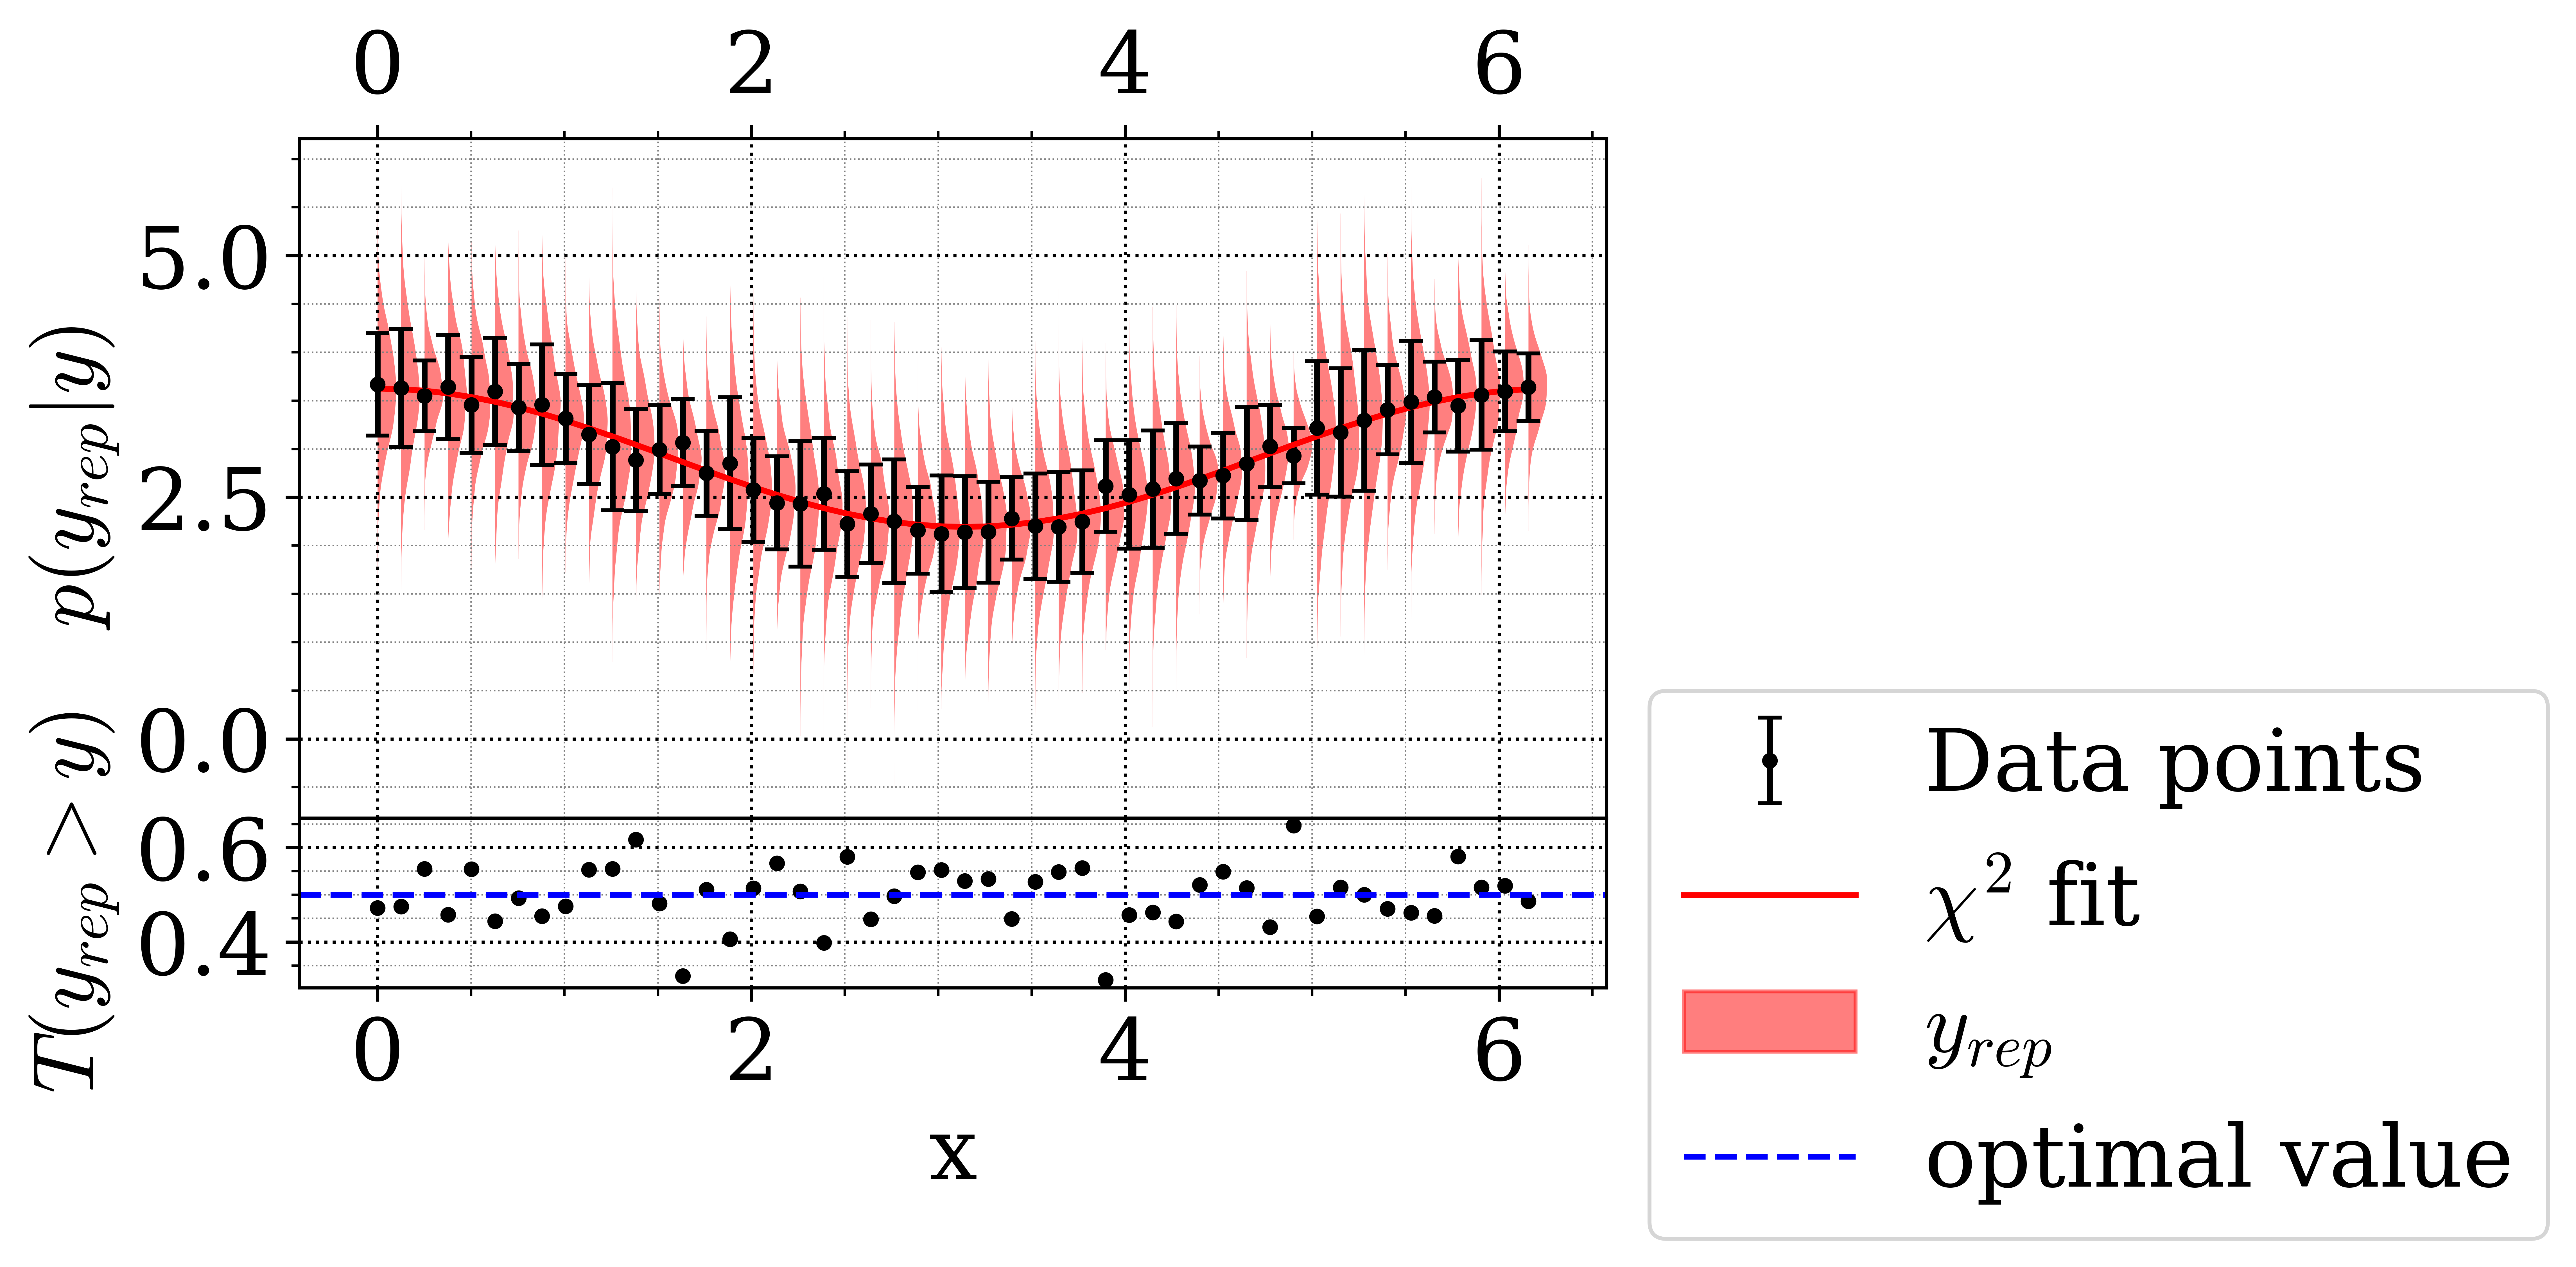

In [8]:
#cosmetics
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
#get results from chisq fit and plot them
yfit=f(data['x'],*popt)
ax.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='Data points')
#ax.plot(data['x'],data['y'],'x',label='Data points')
ax.plot(data['x'],yfit,'r-',label='$\chi^2$ fit',color='r')
#violinplot for the replicated samples
vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    #b.set_color('red')

#compute p value as measure of goodness of fit
y_arr=[samples[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
#plot pvalue
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
#cosmetics and legend
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
tmp=lines[0]
lines[0]=lines[1]
lines[1]=tmp
plt.legend(handles=lines,bbox_to_anchor=(1,2))
plt.savefig('plot.pdf',format='pdf',bbox_inches='tight',dpi=1000)


(array([ 2.,  0.,  2.,  5., 12., 10.,  7., 10.,  0.,  2.]),
 array([0.3195  , 0.352225, 0.38495 , 0.417675, 0.4504  , 0.483125,
        0.51585 , 0.548575, 0.5813  , 0.614025, 0.64675 ]),
 <BarContainer object of 10 artists>)

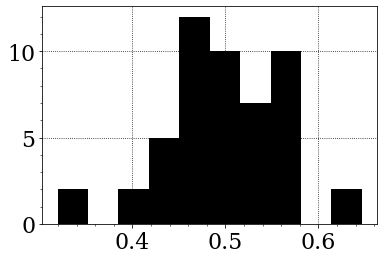

In [9]:
plt.hist(pvalue)

In [10]:
pwaic=sum([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(50)])
lpd=sum([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(50)])
print(lpd-pwaic)

-14.410641732701125


In [11]:
model1= sp.CmdStanModel(stan_file='./stan_file1.stan')
fit1 = model1.sample(data=stan_data)
fit1.summary()
samples1=fit1.draws_pd()

INFO:cmdstanpy:compiling stan program, exe file: /Users/jakob/Documents/Studium/master_thesis/bayes/stan_file1
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/stan_file1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [ ]:
az.plot_trace(fit1)
plt.show()

In [ ]:
#cosmetics
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
#get results from chisq fit and plot them
yfit1=f1(data['x'],*popt1)
ax.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='Data points')
#ax.plot(data['x'],data['y'],'x',label='Data points')
ax.plot(data['x'],yfit1,'r-',label='$\chi^2$ fit',color='r')
#violinplot for the replicated samples
vp=ax.violinplot([samples1[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    #b.set_color('red')

#compute p value as measure of goodness of fit
y_arr=[samples1[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
#plot pvalue
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
#cosmetics and legend
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
tmp=lines[0]
lines[0]=lines[1]
lines[1]=tmp
plt.legend(handles=lines,bbox_to_anchor=(1,2))
plt.savefig('plot1.pdf',format='pdf',bbox_inches='tight',dpi=1000)

In [ ]:
pwaic1=sum([np.var(samples2[f'log_lik[{i+1}]'], ddof=1)for i in range(50)])
lpd1=sum([np.log(np.mean(np.exp(samples1[f'log_lik[{i+1}]'])))for i in range(50)])
print(lpd1-pwaic1)